In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout ,SimpleRNN , Bidirectional
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
var='BTC'

In [33]:
df = pd.read_csv(f'Dataset/{var}-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [34]:
ma100 = df['Close'].rolling(100).mean()

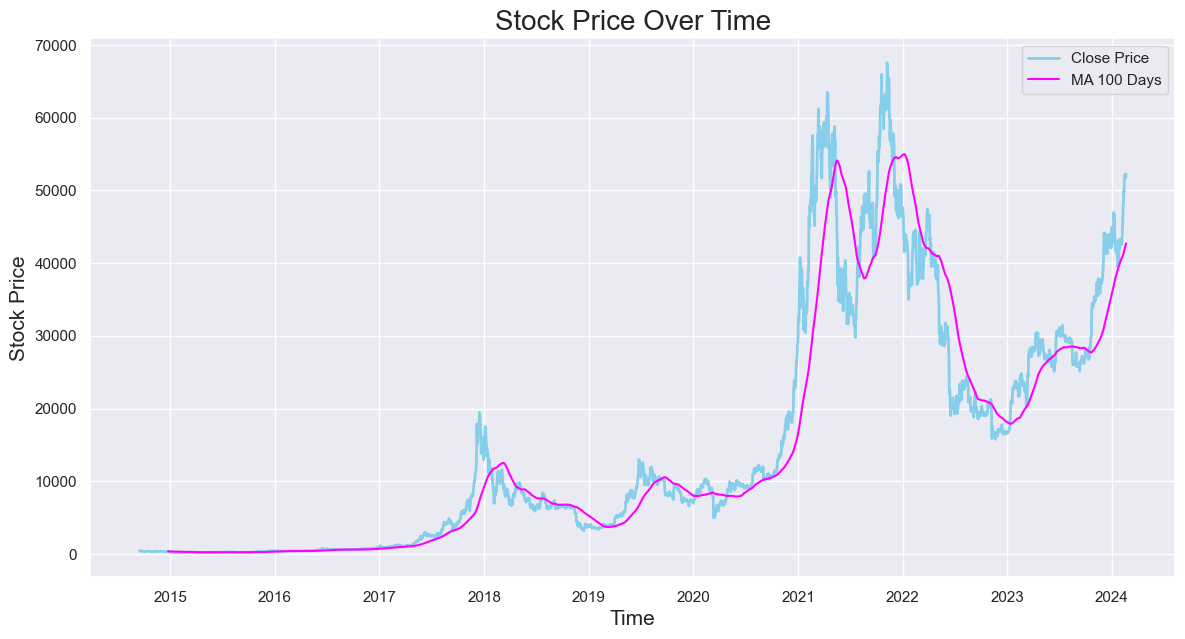

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

plt.plot(df.index, df['Close'], color='skyblue', label='Close Price', linewidth=2)

plt.plot(ma100, color='magenta', label='MA 100 Days', linewidth=1.5)

plt.title('Stock Price Over Time', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)

plt.legend()

plt.grid(True)


plt.show()

In [36]:
scaler = MinMaxScaler(feature_range=(-1, 1))
def create_dataset(df, window):
    scaled_data = scaler.fit_transform(df[['Close']])

    X = []
    y = []

    for i in range(window, len(scaled_data)):
        X.append(scaled_data[i-window:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    
    return X, y

In [37]:
def test_train_split(X,y):
    cv_size = int(0.2 * len(X))

    start_idx = np.random.randint(0, len(X) - cv_size)

    X_cv = X[start_idx:start_idx+cv_size]
    y_cv = y[start_idx:start_idx+cv_size]

    X_train = np.delete(X, np.s_[start_idx:start_idx+cv_size], axis=0)
    y_train = np.delete(y, np.s_[start_idx:start_idx+cv_size], axis=0)

    train_size = int(0.8 * len(X_train))
    X_train1, X_test = X_train[:train_size], X_train[train_size:]
    y_train1, y_test = y_train[:train_size], y_train[train_size:]

    return X_train1 , X_test , y_train1,y_test , X_cv,y_cv


In [38]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metrics(y_test,pred,model):
    rmse = np.sqrt(mean_squared_error(y_test.reshape(-1,1),pred))
    r2 = r2_score(y_test.reshape(-1,1), pred)
    mae = mean_absolute_error(y_test.reshape(-1,1), pred)
    mape_score = mape(y_test.reshape(-1,1), pred)
    print(f"{model}\nrmse:{rmse}\nr2:{r2}\nmae:{mae}\nmape:{mape_score}\n\n")

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(predictions_, var):
    # Set the Seaborn theme
    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], color='red', label=f'Real {var} Price', linewidth=2.5)
    plt.plot(df.index[len(df) - len(predictions_):], predictions_, color='blue', label=f'Predicted {var} Price (LSTM)', linewidth=2.5)
    
    plt.title(f'{var} Price Prediction', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(f'{var} Price', fontsize=14)
    plt.legend(fontsize=12)
    
    # Optionally, use Seaborn's despine to remove the top and right spines
    sns.despine()

    plt.show()

# Novel Model => Stacked LSTM 

In [40]:
X, y = create_dataset(df, 40)
X_train1 , X_test,y_train1,y_test,X_cv,y_cv=test_train_split(X,y)

In [41]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(40,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

c:\Users\saket\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 40, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 40, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history=model.fit(X_train1,y_train1,epochs=100,batch_size=32,validation_data=(X_cv,y_cv))

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.2324 - val_loss: 0.0252
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0646 - val_loss: 0.0320
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0545 - val_loss: 0.0243
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0497 - val_loss: 0.0331
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0460 - val_loss: 0.0446
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0501 - val_loss: 0.0430
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0455 - val_loss: 0.0431
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0440 - val_loss: 0.0296
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0458 - val_loss: 0.0310
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0452 - val_loss: 0.0286
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0389 - val_loss: 0.0216
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

In [45]:
model.save(f'novel_model_{var}.h5')

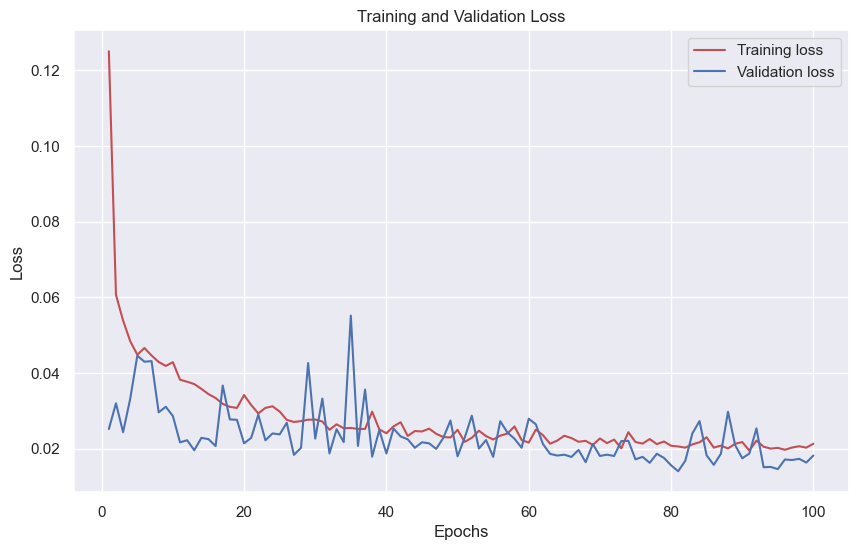

In [46]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the 'fit' method
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss',)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1,1))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [48]:
metrics(scaler.inverse_transform(y_test),predictions_inverse,"Base Model Inverse Scaled Metrics")

Base Model Inverse Scaled Metrics
rmse:1340.3515234416213
r2:0.9753763748644133
mae:1093.9096849308487
mape:3.7876462825955803




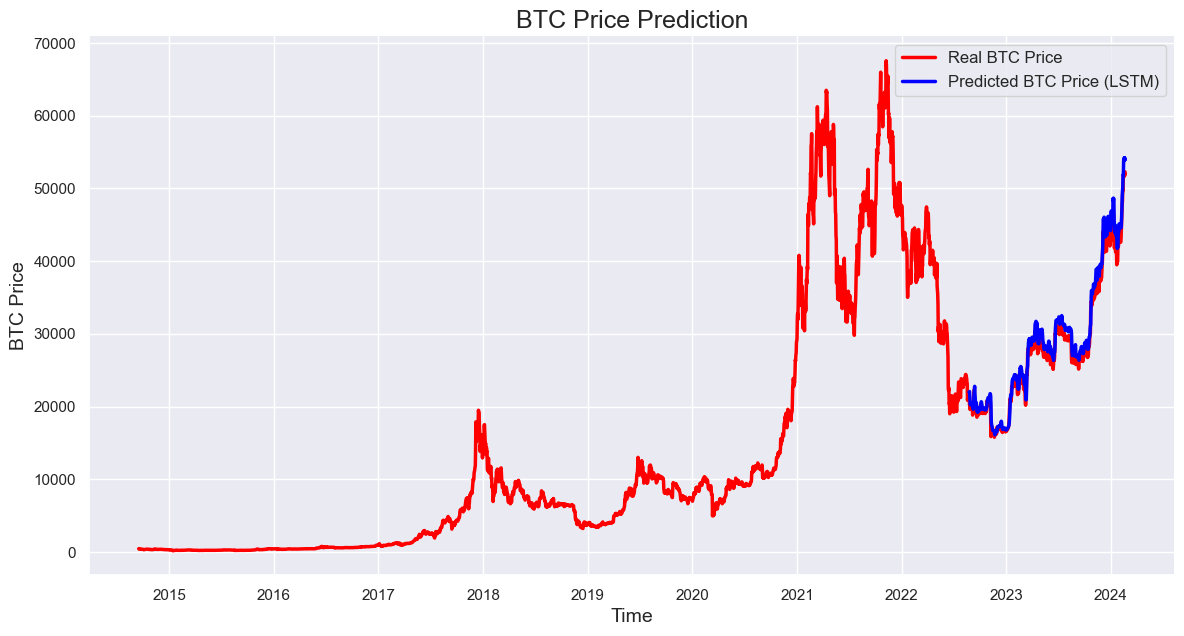

In [49]:
plot_predictions(predictions_inverse,var)